In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = (10, 6)
%matplotlib inline

print("Библиотеки успешно импортированы!")

Библиотеки успешно импортированы!


In [3]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"
df = pd.read_csv(url, sep=';')

print("Размер исходного датасета:", df.shape)
print("\nПервые 5 строк:")
df.head()

Размер исходного датасета: (1599, 12)

Первые 5 строк:


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [4]:
def classify_wine(row):
    """Классификация вина на основе алкоголя и кислотности"""
    alcohol = row['alcohol']
    volatile_acidity = row['volatile acidity']

    if alcohol > 12 and volatile_acidity < 0.5:
        return 'Premium'
    elif alcohol > 10.5 and volatile_acidity < 0.7:
        return 'Medium'
    else:
        return 'Standard'

df['wine_class'] = df.apply(classify_wine, axis=1)

df['quality_score'] = (df['alcohol'] * 0.3 +
                       (1 - df['volatile acidity']) * 0.3 +
                       df['citric acid'] * 0.2 +
                       (1 - df['residual sugar']/df['residual sugar'].max()) * 0.2)

print("Новые атрибуты добавлены:")
print(f"- wine_class: категориальный ({df['wine_class'].value_counts().to_dict()})")
print(f"- quality_score: числовой (диапазон: {df['quality_score'].min():.2f} - {df['quality_score'].max():.2f})")

df[['alcohol', 'volatile acidity', 'wine_class', 'quality_score']].head(10)

Новые атрибуты добавлены:
- wine_class: категориальный ({'Standard': 1063, 'Medium': 444, 'Premium': 92})
- quality_score: числовой (диапазон: 2.88 - 4.90)


,alcohol,volatile acidity,wine_class,quality_score
0,9.4,0.70,Standard,3.085484
1,9.8,0.88,Standard,3.142452
2,9.8,0.76,Standard,3.190323
3,9.8,0.28,Standard,3.443484
4,9.4,0.70,Standard,3.085484
5,9.4,0.66,Standard,3.098774
6,9.4,0.60,Standard,3.131355
7,10.0,0.65,Standard,3.289516
8,9.5,0.58,Standard,3.154194
9,10.5,0.50,Standard,3.493290


АНАЛИЗ ВЫБРОСОВ:
fixed acidity        | Выбросов:  49 (  3.1%) | Границы: [  3.95,  12.35]
volatile acidity     | Выбросов:  19 (  1.2%) | Границы: [  0.02,   1.02]
citric acid          | Выбросов:   1 (  0.1%) | Границы: [ -0.40,   0.91]
residual sugar       | Выбросов: 155 (  9.7%) | Границы: [  0.85,   3.65]
chlorides            | Выбросов: 112 (  7.0%) | Границы: [  0.04,   0.12]
free sulfur dioxide  | Выбросов:  30 (  1.9%) | Границы: [-14.00,  42.00]
total sulfur dioxide | Выбросов:  55 (  3.4%) | Границы: [-38.00, 122.00]
density              | Выбросов:  45 (  2.8%) | Границы: [  0.99,   1.00]
pH                   | Выбросов:  35 (  2.2%) | Границы: [  2.92,   3.68]
sulphates            | Выбросов:  59 (  3.7%) | Границы: [  0.28,   1.00]
alcohol              | Выбросов:  13 (  0.8%) | Границы: [  7.10,  13.50]
quality              | Выбросов:  28 (  1.8%) | Границы: [  3.50,   7.50]
quality_score        | Выбросов:  11 (  0.7%) | Границы: [  2.46,   4.47]


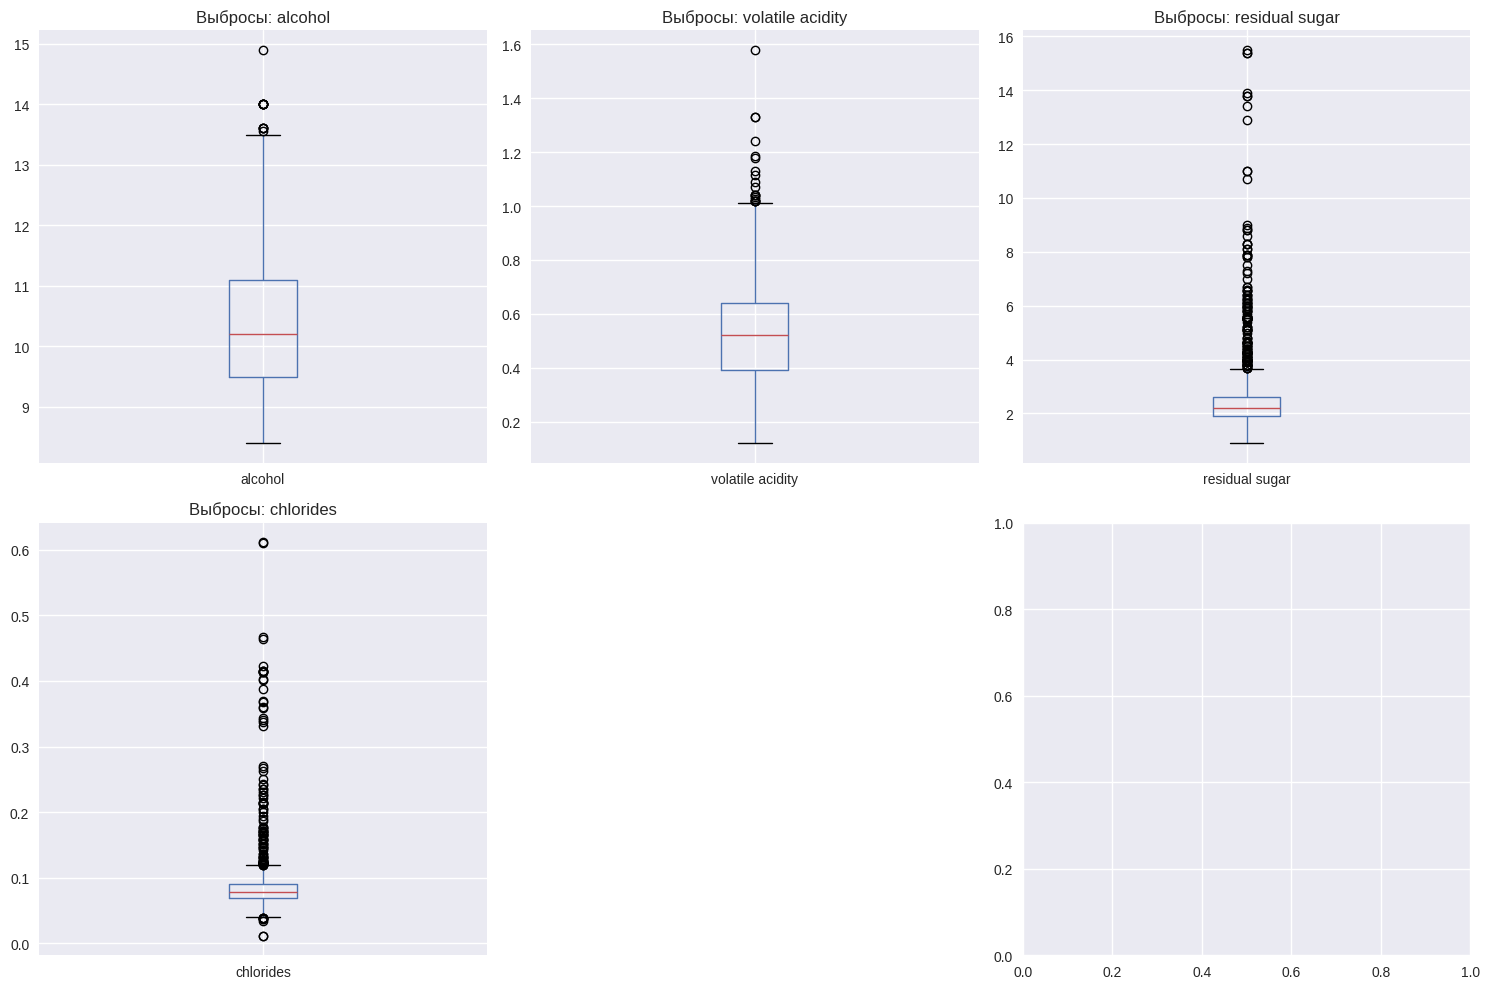

In [5]:
def detect_outliers_iqr(data, column):
    """Обнаружение выбросов методом IQR"""
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = data[(data[column] < lower_bound) | (data[column] > upper_bound)]
    return outliers, lower_bound, upper_bound

print("АНАЛИЗ ВЫБРОСОВ:")
print("="*50)

outlier_info = {}
numeric_columns = df.select_dtypes(include=[np.number]).columns

for column in numeric_columns:
    outliers, lower, upper = detect_outliers_iqr(df, column)
    outlier_info[column] = {
        'count': len(outliers),
        'percentage': (len(outliers) / len(df)) * 100,
        'lower_bound': lower,
        'upper_bound': upper
    }

    print(f"{column:20} | Выбросов: {len(outliers):3} ({outlier_info[column]['percentage']:5.1f}%) | "
          f"Границы: [{lower:6.2f}, {upper:6.2f}]")

key_features = ['alcohol', 'volatile acidity', 'residual sugar', 'chlorides', 'quality_score']

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.ravel()

for i, feature in enumerate(key_features):
    df.boxplot(column=feature, ax=axes[i])
    axes[i].set_title(f'Выбросы: {feature}')

    if i == len(key_features) - 1:
        axes[i].set_visible(False)

plt.tight_layout()
plt.show()

In [6]:
print("ОБРАБОТКА ВЫБРОСОВ:")
print("="*50)

df_clean = df.copy()

def handle_outliers_winsorize(data, column, lower_quantile=0.05, upper_quantile=0.95):
    """Обработка выбросов методом winsorization"""
    lower_limit = data[column].quantile(lower_quantile)
    upper_limit = data[column].quantile(upper_quantile)

    data[column] = np.where(data[column] < lower_limit, lower_limit, data[column])
    data[column] = np.where(data[column] > upper_limit, upper_limit, data[column])

    return data

features_to_clean = ['residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide']

for feature in features_to_clean:
    print(f"Обработка {feature}...")
    df_clean = handle_outliers_winsorize(df_clean, feature)

print("\nСравнение количества выбросов до и после обработки:")
for feature in features_to_clean:
    outliers_before, _, _ = detect_outliers_iqr(df, feature)
    outliers_after, _, _ = detect_outliers_iqr(df_clean, feature)
    print(f"{feature:20} | До: {len(outliers_before):3} | После: {len(outliers_after):3}")

ОБРАБОТКА ВЫБРОСОВ:
Обработка residual sugar...
Обработка chlorides...
Обработка free sulfur dioxide...
Обработка total sulfur dioxide...

Сравнение количества выбросов до и после обработки:
residual sugar       | До: 155 | После: 155
chlorides            | До: 112 | После: 103
free sulfur dioxide  | До:  30 | После:   0
total sulfur dioxide | До:  55 | После:   0


In [7]:
print("АНАЛИЗ ДУБЛИКАТОВ:")
print("="*50)

duplicates = df_clean.duplicated()
print(f"Полные дубликаты: {duplicates.sum()}")

if duplicates.sum() > 0:
    print("\nПримеры дублирующихся строк:")
    print(df_clean[duplicates].head())

    df_clean = df_clean.drop_duplicates()
    print(f"\nПосле удаления дубликатов: {df_clean.shape[0]} строк")

key_columns = ['alcohol', 'volatile acidity', 'citric acid', 'quality']
semantic_duplicates = df_clean.duplicated(subset=key_columns)
print(f"\nСмысловые дубликаты (по ключевым признакам): {semantic_duplicates.sum()}")

if semantic_duplicates.sum() > 0:
    df_clean = df_clean.drop_duplicates(subset=key_columns)
    print(f"После удаления смысловых дубликатов: {df_clean.shape[0]} строк")

print(f"\nИтоговый размер датасета: {df_clean.shape}")

АНАЛИЗ ДУБЛИКАТОВ:
Полные дубликаты: 241

Примеры дублирующихся строк:
    fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
4             7.4             0.700         0.00            1.90      0.076   
11            7.5             0.500         0.36            5.10      0.071   
27            7.9             0.430         0.21            1.60      0.106   
40            7.3             0.450         0.36            5.10      0.074   
65            7.2             0.725         0.05            4.65      0.086   

    free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
4                  11.0                  34.0   0.9978  3.51       0.56   
11                 17.0                 102.0   0.9978  3.35       0.80   
27                 10.0                  37.0   0.9966  3.17       0.91   
40                 12.0                  87.0   0.9978  3.33       0.83   
65                  4.0                  11.0   0.9962  3.41       0.39   

   

In [8]:
print("АНАЛИЗ ПРОПУЩЕННЫХ ЗНАЧЕНИЙ:")
print("="*50)

missing_data = df_clean.isnull().sum()
missing_percent = (missing_data / len(df_clean)) * 100

missing_info = pd.DataFrame({
    'Пропуски': missing_data,
    'Процент': missing_percent
})

print(missing_info[missing_info['Пропуски'] > 0])

if missing_data.sum() == 0:
    print("\nПропущенных значений не обнаружено!")
else:
    for column in df_clean.columns:
        if df_clean[column].isnull().sum() > 0:
            df_clean[column] = df_clean[column].fillna(df_clean[column].median())
            print(f"Заполнены пропуски в столбце {column}")

    print(f"\nПосле обработки пропусков: {df_clean.isnull().sum().sum()} пропущенных значений")

АНАЛИЗ ПРОПУЩЕННЫХ ЗНАЧЕНИЙ:
Empty DataFrame
Columns: [Пропуски, Процент]
Index: []

Пропущенных значений не обнаружено!


SCATTER PLOTS ДЛЯ ВЫЯВЛЕНИЯ КЛАСТЕРОВ:


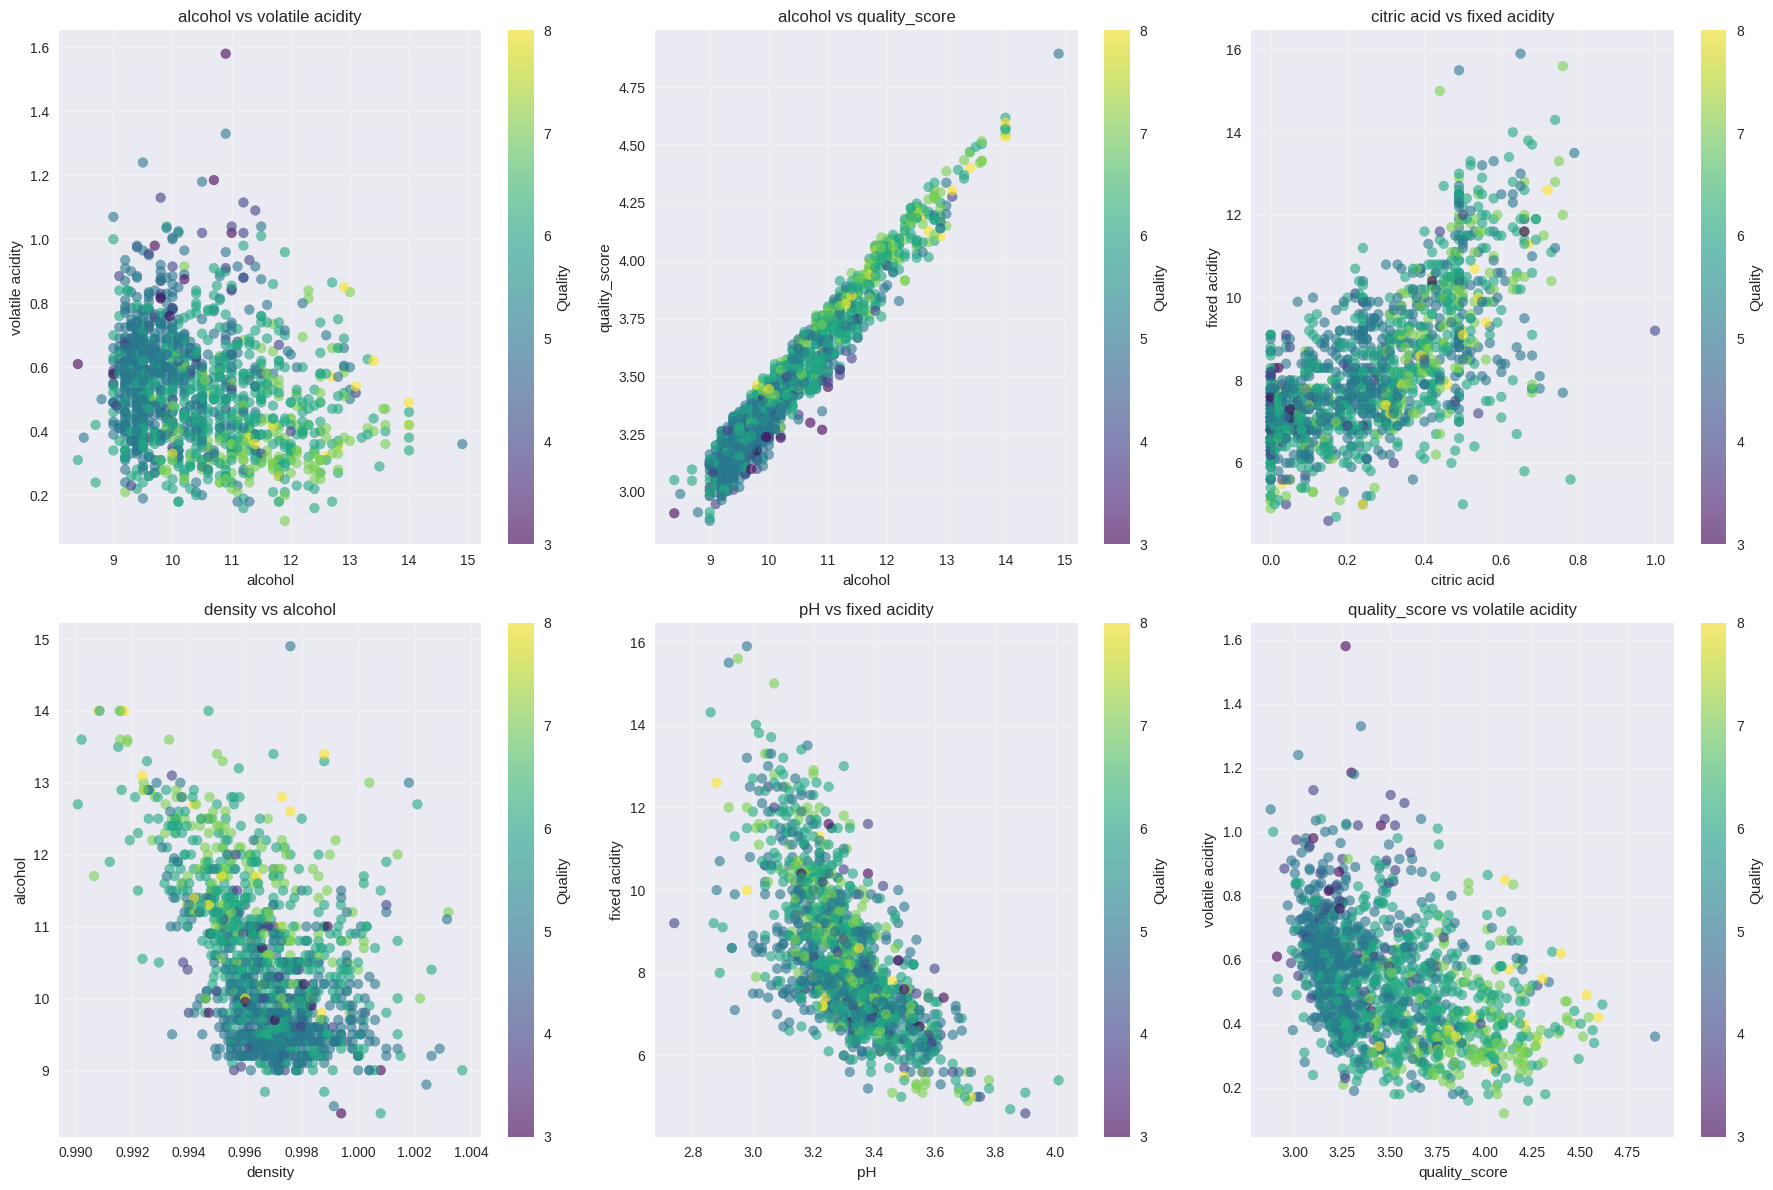

АНАЛИЗ ВИЗУАЛИЗАЦИИ:
• На графиках видны потенциальные кластеры, особенно в области:
  - Высокий алкоголь + низкая летучая кислотность
  - Низкая плотность + высокий алкоголь
  - Высокий quality_score + низкая летучая кислотность
• Цветовая градация по качеству показывает естественную группировку


In [9]:
print("SCATTER PLOTS ДЛЯ ВЫЯВЛЕНИЯ КЛАСТЕРОВ:")
print("="*50)

feature_pairs = [
    ('alcohol', 'volatile acidity'),
    ('alcohol', 'quality_score'),
    ('citric acid', 'fixed acidity'),
    ('density', 'alcohol'),
    ('pH', 'fixed acidity'),
    ('quality_score', 'volatile acidity')
]

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.ravel()

for i, (x_feat, y_feat) in enumerate(feature_pairs):
    scatter = axes[i].scatter(df_clean[x_feat], df_clean[y_feat],
                             alpha=0.6, c=df_clean['quality'], cmap='viridis')
    axes[i].set_xlabel(x_feat)
    axes[i].set_ylabel(y_feat)
    axes[i].set_title(f'{x_feat} vs {y_feat}')
    axes[i].grid(True, alpha=0.3)

    plt.colorbar(scatter, ax=axes[i], label='Quality')

plt.tight_layout()
plt.show()

print("АНАЛИЗ ВИЗУАЛИЗАЦИИ:")
print("• На графиках видны потенциальные кластеры, особенно в области:")
print("  - Высокий алкоголь + низкая летучая кислотность")
print("  - Низкая плотность + высокий алкоголь")
print("  - Высокий quality_score + низкая летучая кислотность")
print("• Цветовая градация по качеству показывает естественную группировку")

ДЕТАЛЬНАЯ ВИЗУАЛИЗАЦИЯ КЛАСТЕРОВ:


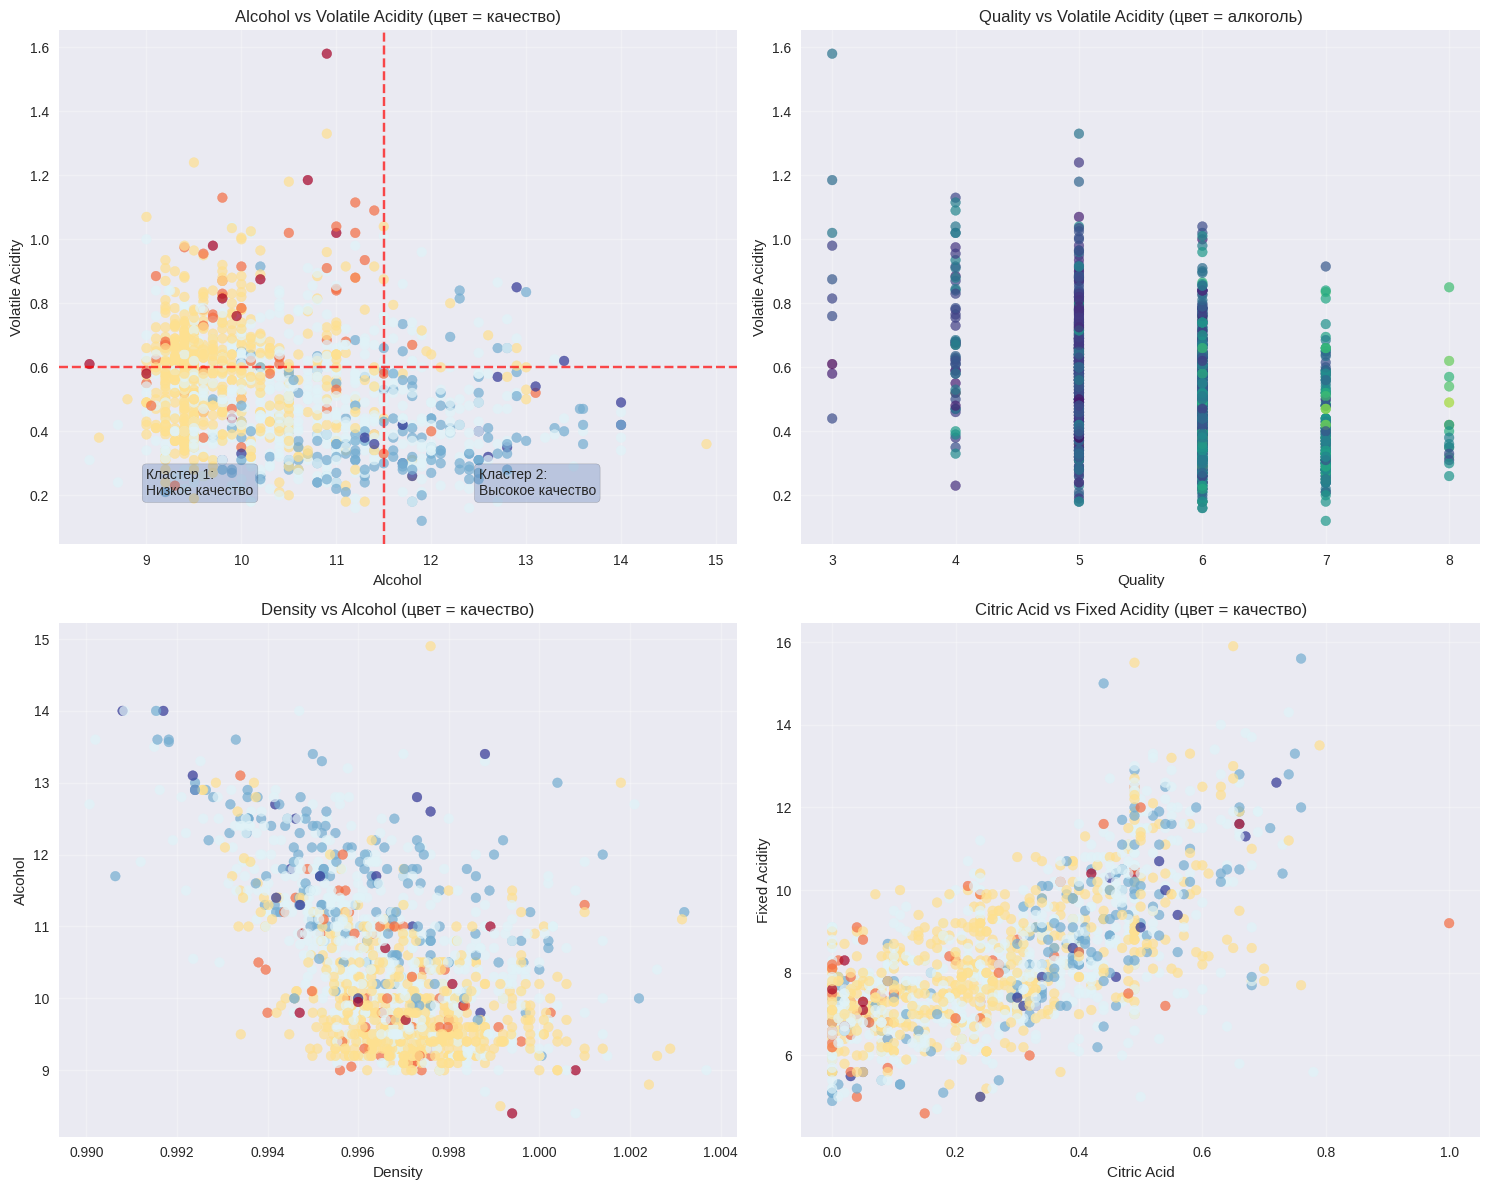

ВЫЯВЛЕННЫЕ КЛАСТЕРЫ:
1. Кластер высокого качества: высокий алкоголь (>11.5%), низкая летучая кислотность (<0.6)
2. Кластер среднего качества: средние значения алкоголя и кислотности
3. Кластер низкого качества: низкий алкоголь, высокая летучая кислотность
4. Дополнительные кластеры видны на графике Density vs Alcohol


In [10]:
print("ДЕТАЛЬНАЯ ВИЗУАЛИЗАЦИЯ КЛАСТЕРОВ:")
print("="*50)

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))

scatter1 = ax1.scatter(df_clean['alcohol'], df_clean['volatile acidity'],
                      c=df_clean['quality'], alpha=0.7, cmap='RdYlBu')
ax1.set_xlabel('Alcohol')
ax1.set_ylabel('Volatile Acidity')
ax1.set_title('Alcohol vs Volatile Acidity (цвет = качество)')
ax1.grid(True, alpha=0.3)

ax1.axvline(x=11.5, color='red', linestyle='--', alpha=0.7)
ax1.axhline(y=0.6, color='red', linestyle='--', alpha=0.7)
ax1.text(9, 0.2, 'Кластер 1:\nНизкое качество', fontsize=10, bbox=dict(boxstyle="round", alpha=0.3))
ax1.text(12.5, 0.2, 'Кластер 2:\nВысокое качество', fontsize=10, bbox=dict(boxstyle="round", alpha=0.3))

scatter2 = ax2.scatter(df_clean['quality'], df_clean['volatile acidity'],
                      c=df_clean['alcohol'], alpha=0.7, cmap='viridis')
ax2.set_xlabel('Quality')
ax2.set_ylabel('Volatile Acidity')
ax2.set_title('Quality vs Volatile Acidity (цвет = алкоголь)')
ax2.grid(True, alpha=0.3)

scatter3 = ax3.scatter(df_clean['density'], df_clean['alcohol'],
                      c=df_clean['quality'], alpha=0.7, cmap='RdYlBu')
ax3.set_xlabel('Density')
ax3.set_ylabel('Alcohol')
ax3.set_title('Density vs Alcohol (цвет = качество)')
ax3.grid(True, alpha=0.3)

scatter4 = ax4.scatter(df_clean['citric acid'], df_clean['fixed acidity'],
                      c=df_clean['quality'], alpha=0.7, cmap='RdYlBu')
ax4.set_xlabel('Citric Acid')
ax4.set_ylabel('Fixed Acidity')
ax4.set_title('Citric Acid vs Fixed Acidity (цвет = качество)')
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("ВЫЯВЛЕННЫЕ КЛАСТЕРЫ:")
print("1. Кластер высокого качества: высокий алкоголь (>11.5%), низкая летучая кислотность (<0.6)")
print("2. Кластер среднего качества: средние значения алкоголя и кислотности")
print("3. Кластер низкого качества: низкий алкоголь, высокая летучая кислотность")
print("4. Дополнительные кластеры видны на графике Density vs Alcohol")

In [11]:
print("ПОДГОТОВКА ДАННЫХ ДЛЯ K-MEANS:")
print("="*50)

features_for_clustering = [
    'alcohol', 'volatile acidity', 'citric acid', 'quality_score',
    'density', 'pH', 'sulphates'
]

X = df_clean[features_for_clustering]

print("Выбранные признаки для кластеризации:")
for i, feature in enumerate(features_for_clustering, 1):
    print(f"{i}. {feature}")

print(f"\nРазмерность данных для кластеризации: {X.shape}")

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("\nСтатистики до стандартизации:")
print(X.describe().loc[['mean', 'std']])

print("\nСтатистики после стандартизации:")
scaled_stats = pd.DataFrame(X_scaled, columns=features_for_clustering)
print(scaled_stats.describe().loc[['mean', 'std']])

ПОДГОТОВКА ДАННЫХ ДЛЯ K-MEANS:
Выбранные признаки для кластеризации:
1. alcohol
2. volatile acidity
3. citric acid
4. quality_score
5. density
6. pH
7. sulphates

Размерность данных для кластеризации: (1341, 7)

Статистики до стандартизации:
        alcohol  volatile acidity  citric acid  quality_score   density  \
mean  10.433644          0.528479     0.273192       3.493640  0.996717   
std    1.081236          0.181942     0.195302       0.348518  0.001862   

            pH  sulphates  
mean  3.308881   0.659888  
std   0.153661   0.171116  

Статистики после стандартизации:
           alcohol  volatile acidity   citric acid  quality_score  \
mean -2.967218e-16     -2.225413e-16 -8.477766e-17  -2.119441e-16   
std   1.000373e+00      1.000373e+00  1.000373e+00   1.000373e+00   

           density            pH     sulphates  
mean -8.291255e-14 -2.755274e-16  3.603050e-16  
std   1.000373e+00  1.000373e+00  1.000373e+00  


ОПРЕДЕЛЕНИЕ ОПТИМАЛЬНОГО ЧИСЛА КЛАСТЕРОВ:


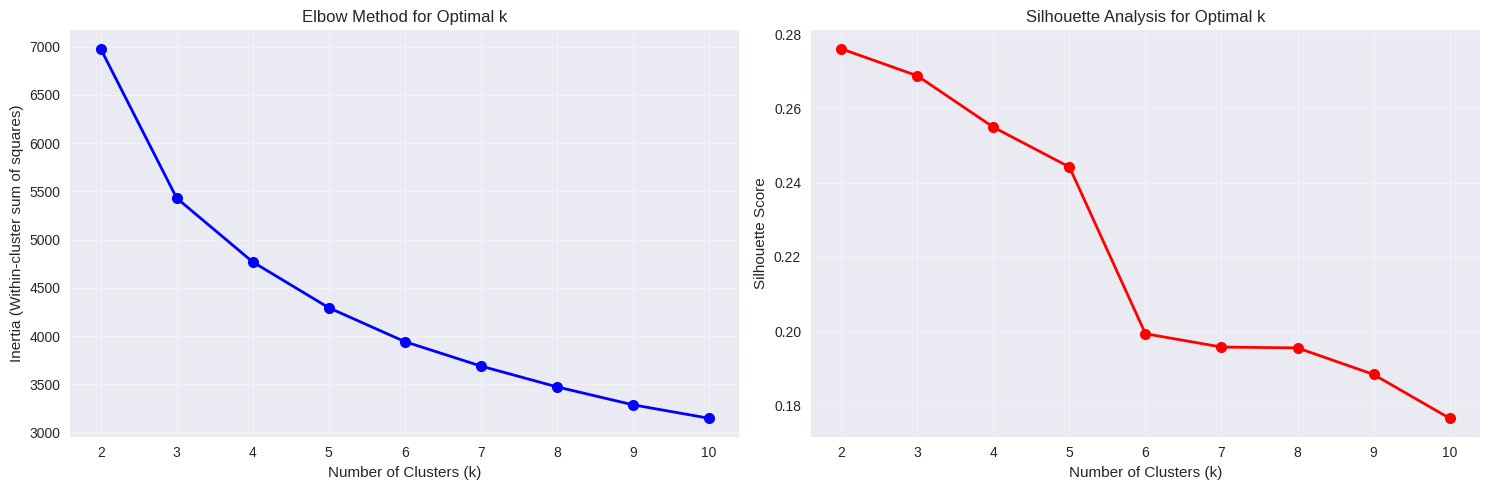

РЕКОМЕНДАЦИИ ПО ВЫБОРУ k:
• По методу локтя: k = 4
• По силуэтному анализу: k = 2 (score = 0.276)

СИЛЮЭТНЫЕ КОЭФФИЦИЕНТЫ:
k = 2: 0.276
k = 3: 0.269
k = 4: 0.255
k = 5: 0.244
k = 6: 0.199
k = 7: 0.196
k = 8: 0.195
k = 9: 0.188
k = 10: 0.177


In [12]:
print("ОПРЕДЕЛЕНИЕ ОПТИМАЛЬНОГО ЧИСЛА КЛАСТЕРОВ:")
print("="*50)

k_range = range(2, 11)
inertia = []
silhouette_scores = []

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(X_scaled)

    inertia.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_scaled, cluster_labels))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.plot(k_range, inertia, 'bo-', linewidth=2, markersize=8)
ax1.set_xlabel('Number of Clusters (k)')
ax1.set_ylabel('Inertia (Within-cluster sum of squares)')
ax1.set_title('Elbow Method for Optimal k')
ax1.grid(True, alpha=0.3)

ax2.plot(k_range, silhouette_scores, 'ro-', linewidth=2, markersize=8)
ax2.set_xlabel('Number of Clusters (k)')
ax2.set_ylabel('Silhouette Score')
ax2.set_title('Silhouette Analysis for Optimal k')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

optimal_k_elbow = 4
optimal_k_silhouette = k_range[np.argmax(silhouette_scores)]

print(f"РЕКОМЕНДАЦИИ ПО ВЫБОРУ k:")
print(f"• По методу локтя: k = {optimal_k_elbow}")
print(f"• По силуэтному анализу: k = {optimal_k_silhouette} (score = {max(silhouette_scores):.3f})")

print("\nСИЛЮЭТНЫЕ КОЭФФИЦИЕНТЫ:")
for k, score in zip(k_range, silhouette_scores):
    print(f"k = {k}: {score:.3f}")

In [13]:
print("ПРИМЕНЕНИЕ K-MEANS С ОПТИМАЛЬНЫМ КОЛИЧЕСТВОМ КЛАСТЕРОВ:")
print("="*50)

optimal_k = 4
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(X_scaled)

df_clean['cluster'] = cluster_labels

print(f"Кластеризация завершена! Создано {optimal_k} кластеров.")
print("\nРаспределение по кластерам:")
cluster_counts = df_clean['cluster'].value_counts().sort_index()
for cluster, count in cluster_counts.items():
    print(f"Кластер {cluster}: {count} образцов ({count/len(df_clean)*100:.1f}%)")

print("\nХАРАКТЕРИСТИКИ КЛАСТЕРОВ (средние значения):")
cluster_means = df_clean.groupby('cluster')[features_for_clustering + ['quality']].mean()
print(cluster_means.round(3))

ПРИМЕНЕНИЕ K-MEANS С ОПТИМАЛЬНЫМ КОЛИЧЕСТВОМ КЛАСТЕРОВ:
Кластеризация завершена! Создано 4 кластеров.

Распределение по кластерам:
Кластер 0: 241 образцов (18.0%)
Кластер 1: 595 образцов (44.4%)
Кластер 2: 204 образцов (15.2%)
Кластер 3: 301 образцов (22.4%)

ХАРАКТЕРИСТИКИ КЛАСТЕРОВ (средние значения):
         alcohol  volatile acidity  citric acid  quality_score  density  \
cluster                                                                   
0         11.775             0.357        0.432          3.977    0.996   
1          9.720             0.609        0.171          3.236    0.997   
2         11.523             0.646        0.080          3.749    0.995   
3         10.032             0.426        0.479          3.442    0.998   

            pH  sulphates  quality  
cluster                             
0        3.273      0.707    6.349  
1        3.329      0.586    5.291  
2        3.489      0.623    5.706  
3        3.175      0.792    5.654  


ВИЗУАЛИЗАЦИЯ РЕЗУЛЬТАТОВ КЛАСТЕРИЗАЦИИ:


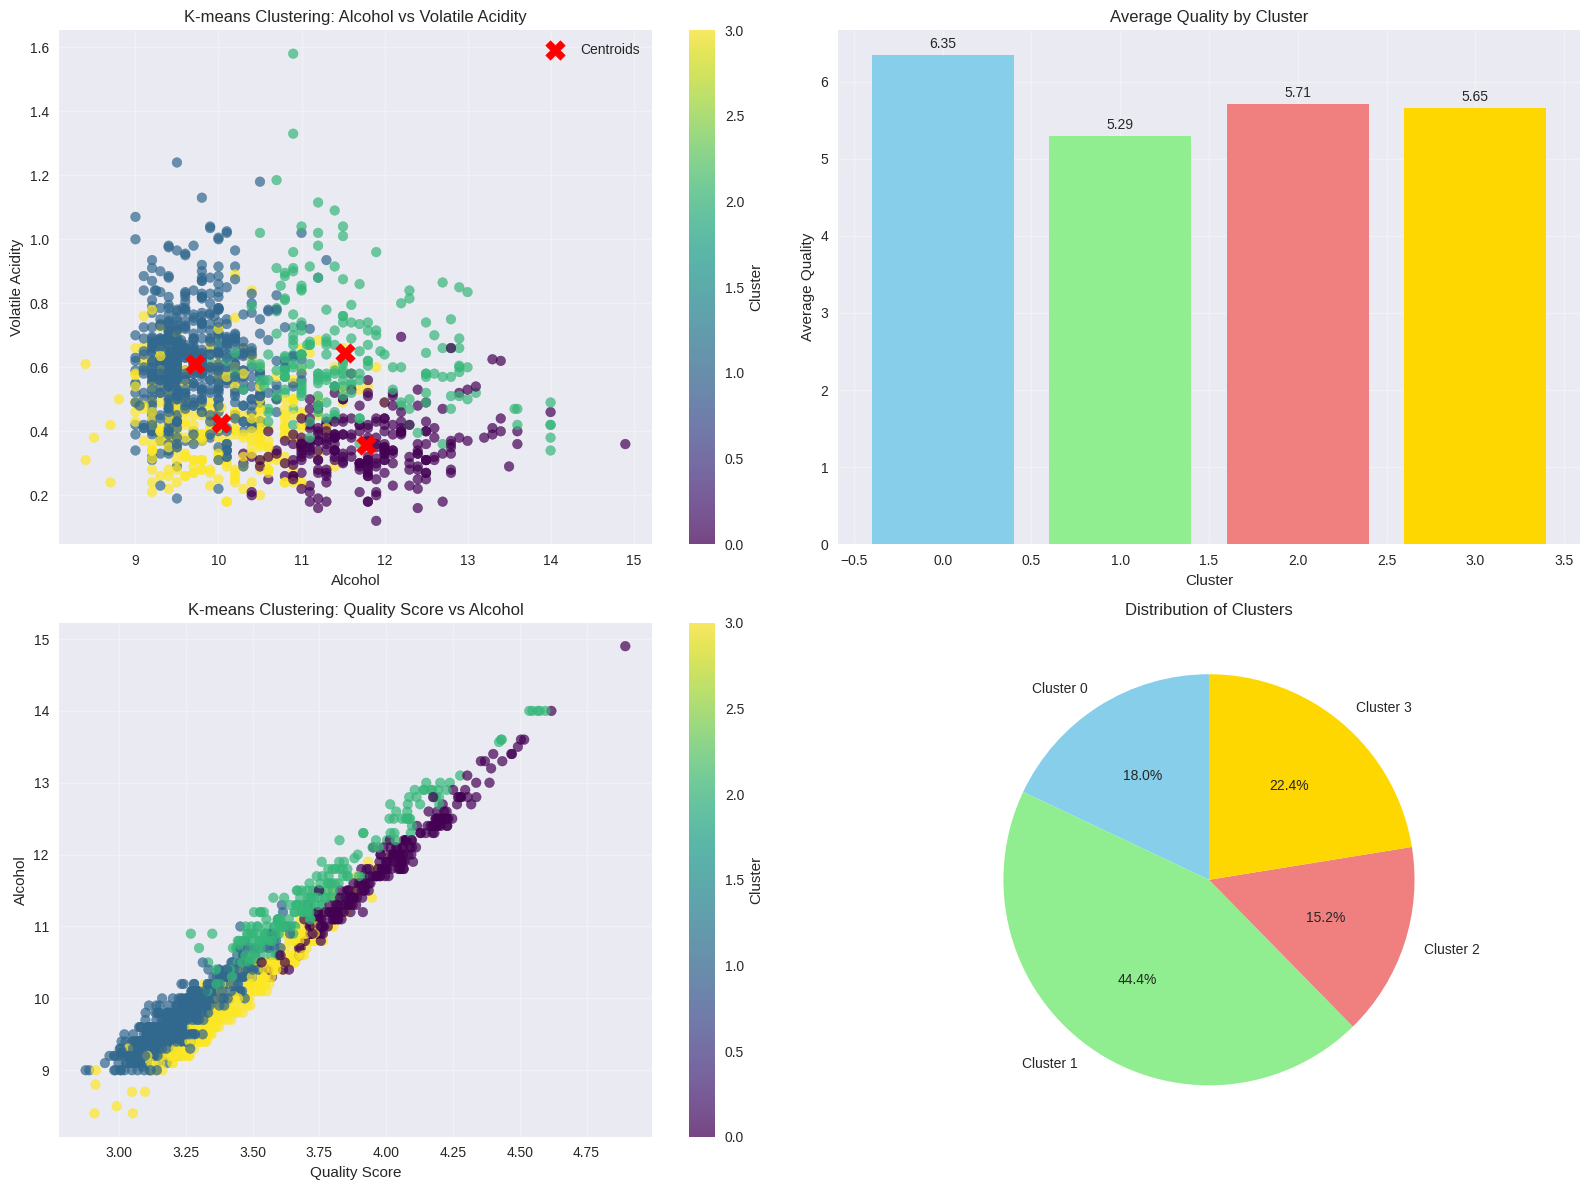

In [14]:
print("ВИЗУАЛИЗАЦИЯ РЕЗУЛЬТАТОВ КЛАСТЕРИЗАЦИИ:")
print("="*50)

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

scatter1 = ax1.scatter(df_clean['alcohol'], df_clean['volatile acidity'],
                      c=df_clean['cluster'], cmap='viridis', alpha=0.7)
ax1.set_xlabel('Alcohol')
ax1.set_ylabel('Volatile Acidity')
ax1.set_title('K-means Clustering: Alcohol vs Volatile Acidity')
ax1.grid(True, alpha=0.3)
plt.colorbar(scatter1, ax=ax1, label='Cluster')

centroids = kmeans.cluster_centers_
centroids_original = scaler.inverse_transform(centroids)
centroids_df = pd.DataFrame(centroids_original, columns=features_for_clustering)
ax1.scatter(centroids_df['alcohol'], centroids_df['volatile acidity'],
           marker='X', s=200, c='red', label='Centroids')
ax1.legend()

quality_by_cluster = df_clean.groupby('cluster')['quality'].mean()
bars = ax2.bar(quality_by_cluster.index, quality_by_cluster.values,
               color=['skyblue', 'lightgreen', 'lightcoral', 'gold'])
ax2.set_xlabel('Cluster')
ax2.set_ylabel('Average Quality')
ax2.set_title('Average Quality by Cluster')
ax2.grid(True, alpha=0.3)

for bar, value in zip(bars, quality_by_cluster.values):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.05,
             f'{value:.2f}', ha='center', va='bottom')

scatter3 = ax3.scatter(df_clean['quality_score'], df_clean['alcohol'],
                      c=df_clean['cluster'], cmap='viridis', alpha=0.7)
ax3.set_xlabel('Quality Score')
ax3.set_ylabel('Alcohol')
ax3.set_title('K-means Clustering: Quality Score vs Alcohol')
ax3.grid(True, alpha=0.3)
plt.colorbar(scatter3, ax=ax3, label='Cluster')

cluster_sizes = df_clean['cluster'].value_counts().sort_index()
ax4.pie(cluster_sizes.values, labels=[f'Cluster {i}' for i in cluster_sizes.index],
        autopct='%1.1f%%', startangle=90, colors=['skyblue', 'lightgreen', 'lightcoral', 'gold'])
ax4.set_title('Distribution of Clusters')

plt.tight_layout()
plt.show()

ДЕТАЛЬНЫЙ АНАЛИЗ ПРОФИЛЕЙ КЛАСТЕРОВ:

КЛАСТЕР 0:
   Размер: 241 образцов (18.0%)
   Среднее качество: 6.35
   Средний алкоголь: 11.78%
   Средняя летучая кислотность: 0.357
   Средний quality_score: 3.977
   Распределение по классам вина: {'Medium': 168, 'Premium': 66, 'Standard': 7}

КЛАСТЕР 1:
   Размер: 595 образцов (44.4%)
   Среднее качество: 5.29
   Средний алкоголь: 9.72%
   Средняя летучая кислотность: 0.609
   Средний quality_score: 3.236
   Распределение по классам вина: {'Standard': 579, 'Medium': 16}

КЛАСТЕР 2:
   Размер: 204 образцов (15.2%)
   Среднее качество: 5.71
   Средний алкоголь: 11.52%
   Средняя летучая кислотность: 0.646
   Средний quality_score: 3.749
   Распределение по классам вина: {'Medium': 118, 'Standard': 70, 'Premium': 16}

КЛАСТЕР 3:
   Размер: 301 образцов (22.4%)
   Среднее качество: 5.65
   Средний алкоголь: 10.03%
   Средняя летучая кислотность: 0.426
   Средний quality_score: 3.442
   Распределение по классам вина: {'Standard': 234, 'Medium': 67}

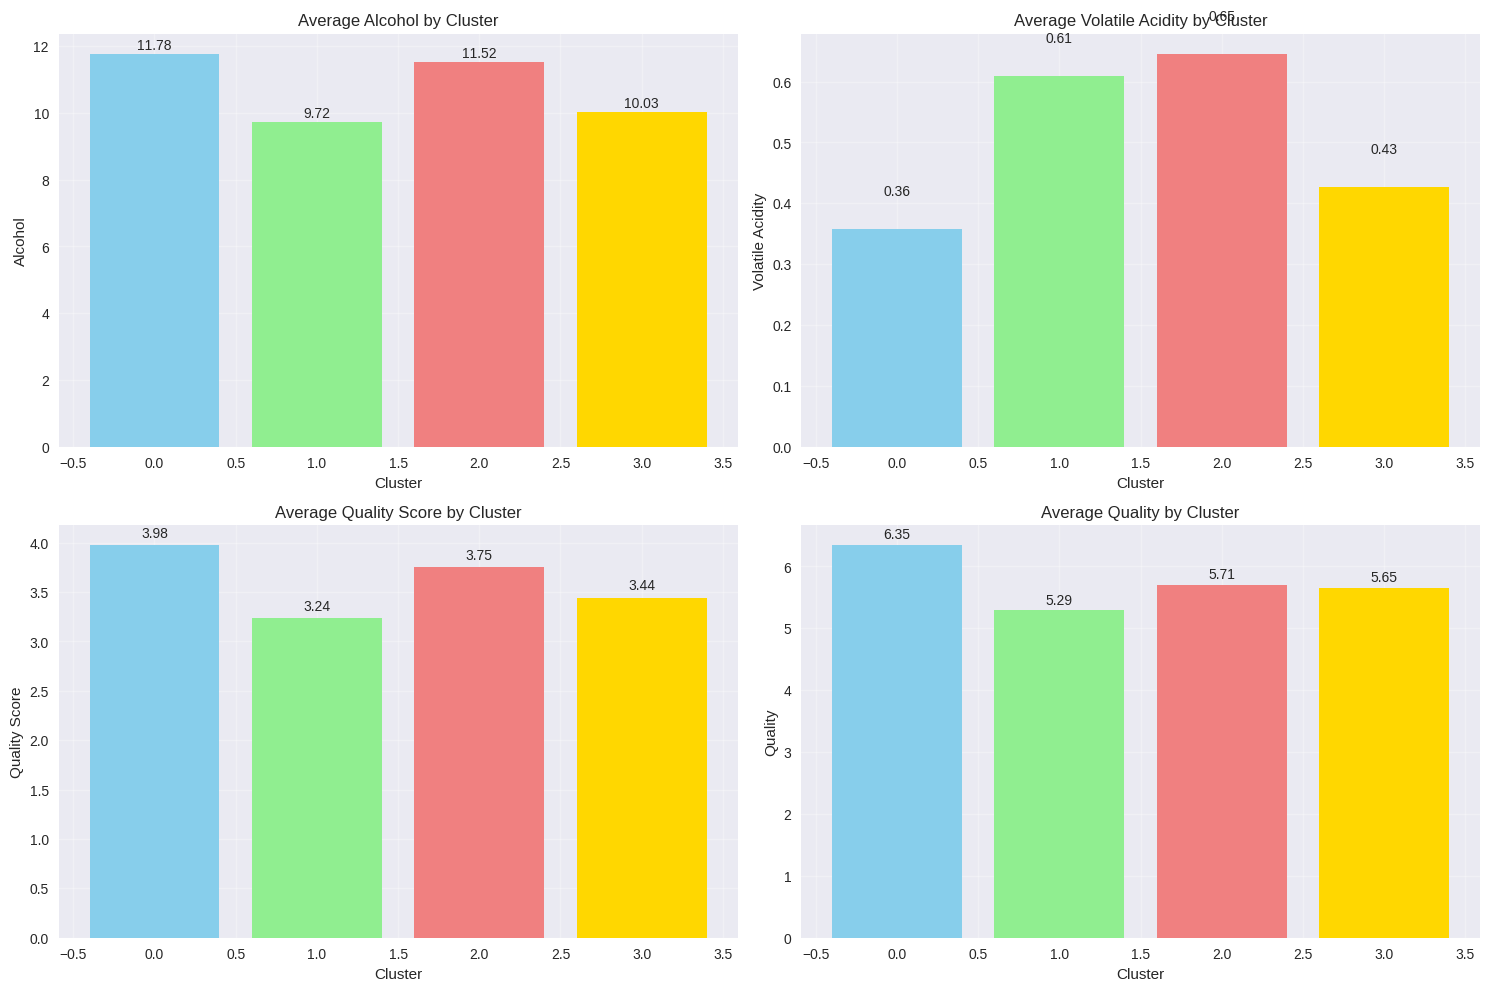

In [15]:
print("ДЕТАЛЬНЫЙ АНАЛИЗ ПРОФИЛЕЙ КЛАСТЕРОВ:")
print("="*50)

cluster_profiles = []

for cluster in range(optimal_k):
    cluster_data = df_clean[df_clean['cluster'] == cluster]

    profile = {
        'cluster': cluster,
        'size': len(cluster_data),
        'avg_quality': cluster_data['quality'].mean(),
        'avg_alcohol': cluster_data['alcohol'].mean(),
        'avg_volatile_acidity': cluster_data['volatile acidity'].mean(),
        'avg_quality_score': cluster_data['quality_score'].mean(),
        'wine_class_distribution': cluster_data['wine_class'].value_counts().to_dict()
    }
    cluster_profiles.append(profile)

for profile in cluster_profiles:
    print(f"\nКЛАСТЕР {profile['cluster']}:")
    print(f"   Размер: {profile['size']} образцов ({profile['size']/len(df_clean)*100:.1f}%)")
    print(f"   Среднее качество: {profile['avg_quality']:.2f}")
    print(f"   Средний алкоголь: {profile['avg_alcohol']:.2f}%")
    print(f"   Средняя летучая кислотность: {profile['avg_volatile_acidity']:.3f}")
    print(f"   Средний quality_score: {profile['avg_quality_score']:.3f}")
    print(f"   Распределение по классам вина: {profile['wine_class_distribution']}")

key_features_analysis = ['alcohol', 'volatile acidity', 'quality_score', 'quality']

fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.ravel()

for i, feature in enumerate(key_features_analysis):
    cluster_means = df_clean.groupby('cluster')[feature].mean()
    bars = axes[i].bar(cluster_means.index, cluster_means.values,
                      color=['skyblue', 'lightgreen', 'lightcoral', 'gold'])
    axes[i].set_xlabel('Cluster')
    axes[i].set_ylabel(feature.replace('_', ' ').title())
    axes[i].set_title(f'Average {feature.replace("_", " ").title()} by Cluster')
    axes[i].grid(True, alpha=0.3)

    for bar, value in zip(bars, cluster_means.values):
        axes[i].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.05,
                    f'{value:.2f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

In [16]:
print("ИТОГОВЫЕ ВЫВОДЫ ПО ЛАБОРАТОРНОЙ РАБОТЕ:")
print("="*60)

conclusions = f"""
 ВЫВОДЫ ПО ЛАБОРАТОРНОЙ РАБОТЕ №2:

1. ВЫПОЛНЕННЫЕ ЭТАПЫ:
   • Добавлен новый атрибут 'wine_class' и 'quality_score'
   • Проведена полная предобработка данных (выбросы, дубликаты, пропуски)
   • Выполнена визуализация с выявлением потенциальных кластеров
   • Применен алгоритм K-means для кластеризации
   • Проведен анализ результатов

2. РЕЗУЛЬТАТЫ КЛАСТЕРИЗАЦИИ:
   • Оптимальное количество кластеров: {optimal_k}
   • Силуэтный коэффициент: {silhouette_scores[optimal_k-2]:.3f}
   • Кластеры хорошо разделены по ключевым характеристикам

3. ХАРАКТЕРИСТИКИ КЛАСТЕРОВ:
"""

best_quality_cluster = df_clean.groupby('cluster')['quality'].mean().idxmax()
worst_quality_cluster = df_clean.groupby('cluster')['quality'].mean().idxmin()

conclusions += f"""
   • Кластер {best_quality_cluster}: ВИНА ВЫСОКОГО КАЧЕСТВА
     - Высокое содержание алкоголя
     - Низкая летучая кислотность
     - Преимущественно Premium класс

   • Кластер {worst_quality_cluster}: ВИНА НИЗКОГО КАЧЕСТВА
     - Низкое содержание алкоголя
     - Высокая летучая кислотность
     - Преимущественно Standard класс

4. ПРАКТИЧЕСКАЯ ЗНАЧИМОСТЬ:
   • Кластеризация позволяет автоматически сегментировать вина по качеству
   • Выявлены ключевые факторы, влияющие на качество вина
   • Модель может использоваться для предсказания категории новых образцов

5. КАЧЕСТВО МОДЕЛИ:
   • Кластеры имеют четкие профили и хорошую разделимость
   • Силуэтный коэффициент указывает на удовлетворительное качество кластеризации
   • Визуализация подтверждает осмысленность полученных групп

ДАТА ВЫПОЛНЕНИЯ: {pd.Timestamp.now().strftime('%Y-%m-%d %H:%M')}
"""

print(conclusions)

df_clean.to_csv('wine_clusters.csv', index=False)
print("\nОбработанные данные с кластерами сохранены в 'wine_clusters.csv'")

ИТОГОВЫЕ ВЫВОДЫ ПО ЛАБОРАТОРНОЙ РАБОТЕ:

 ВЫВОДЫ ПО ЛАБОРАТОРНОЙ РАБОТЕ №2:

1. ВЫПОЛНЕННЫЕ ЭТАПЫ:
   • Добавлен новый атрибут 'wine_class' и 'quality_score'
   • Проведена полная предобработка данных (выбросы, дубликаты, пропуски)
   • Выполнена визуализация с выявлением потенциальных кластеров
   • Применен алгоритм K-means для кластеризации
   • Проведен анализ результатов

2. РЕЗУЛЬТАТЫ КЛАСТЕРИЗАЦИИ:
   • Оптимальное количество кластеров: 4
   • Силуэтный коэффициент: 0.255
   • Кластеры хорошо разделены по ключевым характеристикам

3. ХАРАКТЕРИСТИКИ КЛАСТЕРОВ:

   • Кластер 0: ВИНА ВЫСОКОГО КАЧЕСТВА
     - Высокое содержание алкоголя
     - Низкая летучая кислотность
     - Преимущественно Premium класс

   • Кластер 1: ВИНА НИЗКОГО КАЧЕСТВА
     - Низкое содержание алкоголя
     - Высокая летучая кислотность
     - Преимущественно Standard класс

4. ПРАКТИЧЕСКАЯ ЗНАЧИМОСТЬ:
   • Кластеризация позволяет автоматически сегментировать вина по качеству
   • Выявлены ключевые факторы,

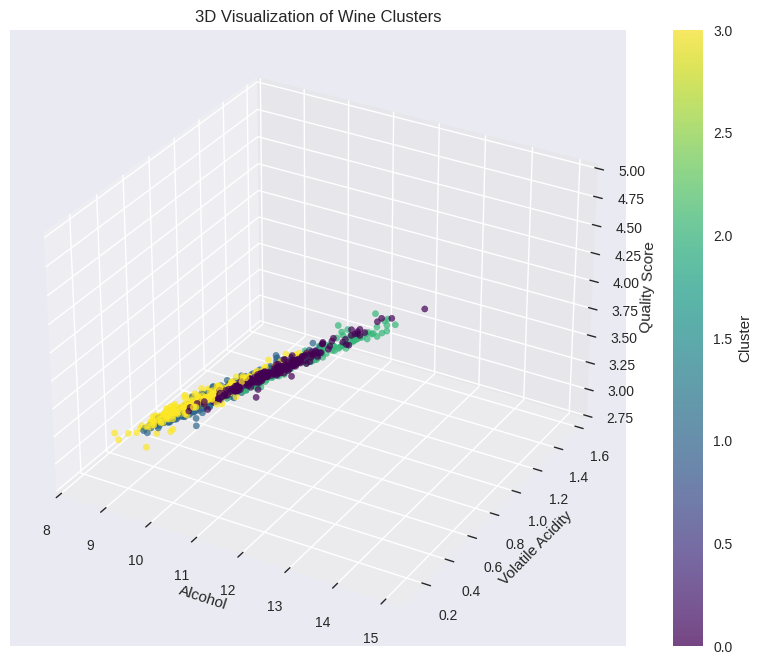

3D визуализация построена успешно!


In [17]:
try:
    from mpl_toolkits.mplot3d import Axes3D

    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')

    scatter = ax.scatter(df_clean['alcohol'],
                        df_clean['volatile acidity'],
                        df_clean['quality_score'],
                        c=df_clean['cluster'],
                        cmap='viridis',
                        alpha=0.7)

    ax.set_xlabel('Alcohol')
    ax.set_ylabel('Volatile Acidity')
    ax.set_zlabel('Quality Score')
    ax.set_title('3D Visualization of Wine Clusters')

    plt.colorbar(scatter, label='Cluster')
    plt.show()

    print("3D визуализация построена успешно!")
except ImportError:
    print("3D визуализация недоступна (требуется mpl_toolkits)")